# 1-Introducción

Basado en: https://medium.com/analytics-vidhya/finetuning-bert-using-ktrain-for-disaster-tweets-classification-18f64a50910b

## Objetivos
Participar en la competencia de Kaggle 'Real or Not', donde se deben utilizar los datos de Tweets que nos brinda Kaggle en 2 archivos CSVs. Debemos clasificar los Tweets que hablan sobre desastres naturales contra los que NO hablan de estos (Y generalmente hablan de los mismos "metafóricamente"). 

Link set de datos y competencia: https://www.kaggle.com/c/nlp-getting-started

De esta manera, como dijimos previamente, debemos identificar y clasificar si los tweets corresponden o no a tweets que hablan sobre catástrofes. Tenemos un dataset 'train' con una columna 'target' donde "etiquetamos" cuales son verdaderos (1) o falsos (0). Identificar esto es una tarea compleja debido a la ambigüedad en la estructura lingüística de los tweets y, por lo tanto, no siempre está claro si las palabras de una persona realmente están anunciando un desastre o no. Por ejemplo, si una persona tuitea:
“On the plus side look at the sky last night, it was ablaze” (En español: 
"En el lado positivo, miré el cielo anoche, estaba en llamas"). 
La expresión 'ablaze' no significa que está en llamas realmente, sino que es una metáfora indicando que el cielo está anaranjado. Para nosotros es fácil entenderlo, pero para las máquinas no lo es. 





## Autorización De Google 

In [3]:
#Esta autorización nos permitirá trabajar en equipo. 
#Además, utilizaremos PyDrive con Google Drive para poder leer los archivos csv de data proporcionados dentro de COLAB.

!pip install -U -q PyDrive          
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Nos autenticamos y creamos el cliente PyDrive:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Importamos Librerias

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2-Preparación de los Datos

## Carga de los datos desde un archivo csv compartido

In [5]:
#Links compartidos para poder usar los archivos CSVs de Google Drive:
#linkCSVTrain= 'https://drive.google.com/open?id=1rGxdJGAymaTUnvPCPcfh9_M16pXrMZex'
linkCSVTest = 'https://drive.google.com/open?id=1FmSet2-IYqxETMAXc3T8DSQgBN-trcwn'
linkCSVTrain = 'https://drive.google.com/open?id=1Fy7AJ2zNn8zZ12mIHAr9SwO9jUV9kI9m'
linkCSVSampleSubmision = 'https://drive.google.com/open?id=1sRXduYV9DcxKipTlJd5x_-yRCqnysvHf'

#Spliteamos para conseguir todo lo que tenga el link después del '=':
fluff, idTrain = linkCSVTrain.split('=')
fluff, idTest = linkCSVTest.split('=')
fluff, idSub = linkCSVSampleSubmision.split('=')

#Guardamos el Data Set en un Dataframe de Pandas en la variable df_disaster_tweets:
downloaded_train = drive.CreateFile({'id':idTrain}) 
downloaded_train.GetContentFile('train.csv')  
downloaded_test = drive.CreateFile({'id':idTest}) 
downloaded_test.GetContentFile('test.csv') 
downloaded_SampleSub = drive.CreateFile({'id':idSub}) 
downloaded_SampleSub.GetContentFile('SampleSubmision.csv') 

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_Sample_Subm = pd.read_csv('SampleSubmision.csv')

## Exploración mínima de los datos (la exploración completa la hicimos en el TP1)


Nuestras Columnas del dataset son:
 - id: Identificador único de cada tweet
 - keyword: Una palabra clave particular de cada tweet (puede ser NaN)
 - location - El lugar donde fue emitido el tweet (puede ser NaN)
 - text: texto del tweet
 - target: Si el tweet trata acerca de un desastre real, el valor es 1, sino 0  (solo en train.csv).

In [6]:
print (df_train.shape, df_test.shape, df_Sample_Subm.shape) 

(7613, 5) (3263, 4) (3263, 2)


In [7]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [9]:
df_Sample_Subm.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


# 3-Aproximación mediante BERT

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de deep learning desarrollado por Google de código abierto. Es utilizado por muchos investigadores e industrias para para resolver muchas tareas de NLP. 

Ktrain (https://github.com/amaiya/ktrain) es un contenedor (wrapper) ligero para la biblioteca de deeplearning TensorFlow Keras (https://www.tensorflow.org/guide/keras/sequential_model) para ayudar a construir, entrenar e implementar ANN's y otros modelos de ML. Diseñado para hacer que el aprendizaje profundo (deep learning) y la IA sean más accesibles y fáciles de aplicar.

Ktrain proporciona soporte para la aplicación de muchas arquitecturas de aprendizaje profundo pre-entrenadas en el dominio de NLP; y BERT es una de ellas. Para resolver este problema, utilizaremos la implementación del BERT pre-entrenado proporcionado por ktrain y lo afinaremos/tunearemos para clasificar si los tweets del desastre son reales o no.

SOLO estamos interesados en la columna TEXTO y TARGET. Las cuales usaremos para clasificar nuestros Tweets.

## Instalamos ktrain

In [12]:
!pip install tensorflow-gpu==2.0.0   #POr error uso keras o tf.keras.
!pip3 install ktrain==0.7.1
#!pip3 install ktrain

## Importamos las librerias para leer el csv de entrenamiento (train.csv)

In [2]:
import tensorflow as tf
print(tf.__version__)

import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split

Leeremos train.csv y realizaremos una división en la columna 'target' donde definiremos el 20% de los datos como el conjunto de validación (validation set).

In [10]:
#Nuestro train.csv está en el DF 'df_train'
random_seed = 12342
x_train, x_val, y_train, y_val = train_test_split(df_train['text'], df_train['target'], shuffle=True, test_size = 0.2, random_state=random_seed, stratify=df_train['target'])

## Convertimos la data en features para BERT

ktrain proporciona una feature muy interesante que nos permite convertir directamente la data de tipo texto en feautures que el modelo necesita. Todo el preprocesamiento del texto no se necesita hacer manualmente... sino que la libreria se encarga de esto. Luego de leer nuestra data de pandas utilizaremos la funciòn 'text_from_array'.

Esta funciòn lo que harà es descargar el modelo de BERT pre-entrenado y su vocabulario. Y en 'preprocess_mode' especificamos 'bert' ya que de esta manera el texto se preprocesarà de una manera especìfica para BERT.

In [11]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                         x_test = x_val, y_test=y_val,
                                                                                          class_names= ["0", "1"],
                                                                                          preprocess_mode='bert',
                                                                                          lang = 'en',
                                                                                          maxlen=65, 
                                                                                          max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


## Cargamos BERT en un objeto 'Learner'

La 1ra funciòn ('text_classifier') carga el modelo pre-entrenado de BERT con una capa Dense final inicializada aleatoriamente. Ya que todas las capas del modelo son entrenables, los pesos de todas las capas del modelo se actualizarán durante el proceso de backpropagation.

La 2da funciòn ('get_learner') crea un objeto 'learner' con data de entrenamiento y data de validaciòn que son usados para "afinar" el clasificador. EL ùltimo paràmetro de 'get_learner' es el "batch size" (usamos un batch size pequeño, de 16).

In [12]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=16)

Is Multi-Label? False
maxlen is 65
done.


## ENTRENAMIENTO ("tuneando" el Clasificador BERT)

Para entrenar el modelo, 1ro buscaremos el learning rate òptimo que funcione para nuestro problema. Ktrain provee un mètodo 'lr_find' que nos permite entrenar al modelo con diferentes learning rates y plotear el loss del modelo a medida que el LR incrementa. 

In [15]:
learner.lr_find()    #SImulamos un entrenamiento para encontrar el mejor LR.

simulating training for different learning rates... this may take a few moments...
Train on 6090 samples
Epoch 1/1024
 128/6090 [..............................] - ETA: 1:17:36 - loss: 0.8209 - acc: 0.3750

## Ploteamos el learning rate:

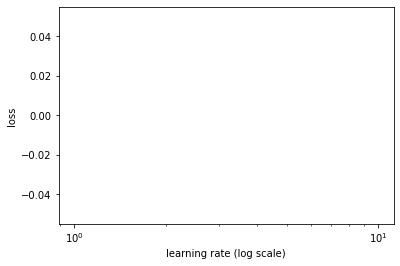

In [17]:
#Para observar el plot del LR:
learner.lr_plot()

Podemos observar que el clasificador provee un loss mìnimo cuando el LR es 1e-5. ENtonces, usamos este LR para entrenar el modelo mediante el mètodo 'autofit'. Este mètodo entrena el clasificador y automàticamente selecciona la mejor performance del modelo previniendo el underfitting y overfitting del mismo.

In [18]:
learner.autofit(1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Train on 6090 samples, validate on 1523 samples
Epoch 1/1024
  16/6090 [..............................] - ETA: 1:26:53 - loss: 0.9178 - acc: 0.3125

KeyboardInterrupt: ignored

In [ ]:
learner.validate(val_data=(x_val_bert, y_val_bert), class_names=['No Disaster', 'Disaster'])

Ahora somos capaces de tener una precisiòn de validaciòn del 84% con un buen F-1 Score para cada una de las clases predichas. 
Luego de entrenar nuestro modelo con el mètodo 'autofit', ahora es tiempo de realizar predicciones sobre la data de TEST.


## Obtenemos la variable predictora

La variable predictora es obtenida pasandole el modelo y el objeto 'preproc' al mètodo 'get_predictor'. Este 'predictor' puede ser usado para realizar predicciones en nuestra data de TEST directamente.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
learner.print_layers()

## Predecimos en el CSV de TEST

In [ ]:
test_df = pd.read_csv("test.csv")
test_df["target"] = predictor.predict(test_df["text"].tolist())

test_df = test_df[["id", "target"]]

In [ ]:
test_df.head()

In [ ]:
test_df.to_csv("submisssions.csv", index=False)

## Subimos las predicciones de TEST a Kaggle

In [ ]:
 and check our score.

Como último paso subimos nuestras predicciones a Kaggle y chequeamos el SCORE obtenido.

VER.... Logramos una precisión del ......83.4% on the test set.

# 3- Conclusiones

Utilizamos las features de Ktrain para implementar de una manera sencilla el complejo modelo de BERT. AL final fuimos capaces de lograr una precisioǹ en TEST de .........

Uno de los mayores problema con BERT es que toma mucho tiempo entrenando. Para mejorar esto, podemos aplicar una versiòn màs ligera de BERT como distilBERT. Tambien, para reducir el tiempo de entrenamiento, los pesos de todas las capas pueden ser congeladas (frozen) a excepciòn de la capa final.